# Neural Network Text Classifier
We explore a few variants of NN classifiers using word embeddings:
<ul>
<li>Perceptron</li>
<li>Perceptron with One-hot vectors</li>
<li>Perceptron with pretrained embeddings</li>
<li>Multilayer perceptron with pretrained embeddings</li>
</ul>
Adapted from code at https://github.com/fchollet/keras/blob/master/examples/imdb_cnn.py

## Import modules

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.layers import Embedding

### Set parameters

In [4]:
max_num_words = 5000
maxlen = 80    # max sentence length
batch_size = 32
embedding_dims = 50
hidden_dims = 250
epochs = 2

## Loading data

Wec need a temporary fix for problems with libraries on the server.

In [5]:
# Fix for:
#    ValueError: Object arrays cannot be loaded when allow_pickle=False
# save np.load
import numpy as np
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [6]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_num_words)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


Pad sequences to `maxlen`

In [7]:
from keras.preprocessing import sequence
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


Show one example

In [8]:
x_train[0]

array([  15,  256,    4,    2,    7, 3766,    5,  723,   36,   71,   43,
        530,  476,   26,  400,  317,   46,    7,    4,    2, 1029,   13,
        104,   88,    4,  381,   15,  297,   98,   32, 2071,   56,   26,
        141,    6,  194,    2,   18,    4,  226,   22,   21,  134,  476,
         26,  480,    5,  144,   30,    2,   18,   51,   36,   28,  224,
         92,   25,  104,    4,  226,   65,   16,   38, 1334,   88,   12,
         16,  283,    5,   16, 4472,  113,  103,   32,   15,   16,    2,
         19,  178,   32], dtype=int32)

## Perceptron

In [9]:
model = Sequential()

We start off with an efficient embedding layer which maps
our vocab indices into embedding_dims dimensions

In [10]:
model.add(Embedding(max_num_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Flatten())

We ad a hidden layer with a single unit output, and squash it with a sigmoid:

In [11]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show the model

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 50)            250000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4001      
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 254,001
Trainable params: 254,001
Non-trainable params: 0
_________________________________________________________________


### Plot model

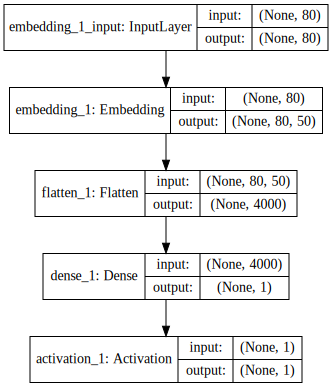

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Training

In [14]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 5s 194us/step - loss: 0.4843 - acc: 0.7644 - val_loss: 0.3579 - val_acc: 0.8397
Epoch 2/2
25000/25000 [==============================] - 5s 191us/step - loss: 0.2830 - acc: 0.8830 - val_loss: 0.3522 - val_acc: 0.8439


### Testing
We already used test data during training to check accuracy on held out data, so this step isn't really necessary.

However, let's see how to do it after the training.

In [15]:
predictions = model.predict(x_test)

In [16]:
predictions

array([[0.1840327 ],
       [0.94908863],
       [0.69655824],
       ...,
       [0.05225854],
       [0.05760246],
       [0.8581921 ]], dtype=float32)

In [17]:
predictions.round()

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

See the correct results

In [18]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

Compare predictions with the correct results

In [19]:
import numpy as np
errors = y_test - predictions.round().flatten()
errors

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [20]:
len(errors[errors==0])

21097

In [21]:
len(errors[errors==0])/len(errors)

0.84388

### Evaluation

In [22]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8439


Plot the accuracy through the epochs

In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

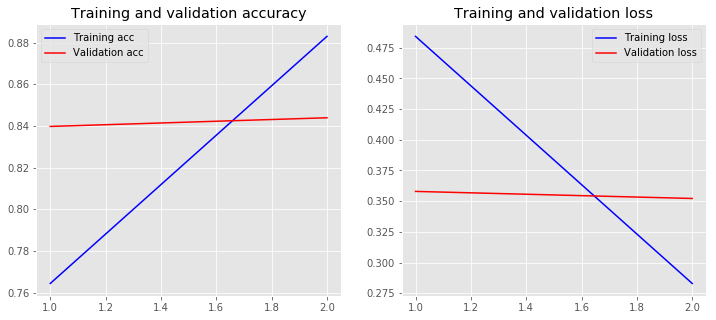

In [24]:
plot_history(history)

## Exploring the embeddings

In [25]:
model.layers

In [26]:
embeddings = model.get_weights()[0]
embeddings.shape

(5000, 50)

In [27]:
embeddings[0]

array([ 0.04311082,  0.03849734,  0.01272706,  0.02223391, -0.02253001,
        0.05245114,  0.01146796, -0.00726316, -0.04307522,  0.00085756,
        0.02722395, -0.03454051,  0.02826435, -0.01682599,  0.03611198,
        0.02131463,  0.01904121, -0.00573929,  0.02156458,  0.01125435,
        0.02576644, -0.04132178,  0.02992379,  0.01937026, -0.03037865,
       -0.013781  ,  0.02469564, -0.04305572,  0.01563062,  0.01162079,
        0.05032681,  0.01942939, -0.03284911, -0.02164467,  0.04773168,
       -0.05659747,  0.00137831, -0.03862633,  0.01031106, -0.03712045,
        0.08441949, -0.03215174, -0.01867423,  0.0599686 , -0.0274315 ,
        0.00449783, -0.05536124,  0.00536627, -0.01782026, -0.02344353],
      dtype=float32)

In [28]:
embeddings[0].dot(embeddings[1])

0.0008895517

## Perceptron with one-hot representations

In [29]:
model_one_hot = Sequential()

This is NOT a real embedding layer, it is just a trick 
to convert words into one-hot representations.

Note that the embeddinfs are not trained, thet never changes during training.

In [30]:
model_one_hot.add(Embedding(max_num_words,
                    max_num_words,
                    embeddings_initializer='identity',
                    input_length=maxlen,
                    trainable=False))  # do not train the embeddings

model_one_hot.add(Flatten())

We add a vanilla hidden layer:

In [31]:
model_one_hot.add(Dense(hidden_dims))
model_one_hot.add(Dropout(0.2))
model_one_hot.add(Activation('relu'))

We project onto a single unit output layer, and squash it with a sigmoid:

In [32]:
model_one_hot.add(Dense(1))
model_one_hot.add(Activation('sigmoid'))

Compile the model:

In [33]:
model_one_hot.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show model

In [34]:
model_one_hot.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 5000)          25000000  
_________________________________________________________________
flatten_2 (Flatten)          (None, 400000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               100000250 
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total para

### Train the model

In [35]:
model_one_hot.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 750s 30ms/step - loss: 0.5887 - acc: 0.6756 - val_loss: 0.5273 - val_acc: 0.7322
Epoch 2/2
25000/25000 [==============================] - 750s 30ms/step - loss: 0.0831 - acc: 0.9700 - val_loss: 0.7634 - val_acc: 0.7191


In [36]:
one_hot = model_one_hot.get_weights()[0]
one_hot.shape

(5000, 5000)

In [37]:
one_hot[0]

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

## Perceptron with pretrained embeddings

Load GloVe embeddings

In [ ]:
import glove
glove_embeddings = glove.Glove.load_stanford('data/glove.6B/glove.6B.50d.txt')

Get the index for the words in the IMDB reviews.

In [ ]:
word_index = imdb.get_word_index()

Create a matrix with embeddings for words in the index

In [ ]:
num_words = min(max_num_words, len(word_index) + 1) # +1 for padding

# Initialize with random weights
word_embeddings = np.random.uniform(-0.2, 0.2, (num_words, 50))

for word, i in word_index.items():
    if i >= num_words:
        continue
    idx = glove_embeddings.dictionary.get(word)
    if idx is not None:
        # words not found in embeddings will have random weights
        word_embeddings[i] = glove_embeddings.word_vectors[idx]

## Multi (2) Layer Perceptron

In [ ]:
from keras.layers import GlobalMaxPool1D

model = Sequential()
model.add(Embedding(word_embeddings.shape[0],
                    word_embeddings.shape[1], 
                    weights=[word_embeddings], 
                    input_length=maxlen, 
                    trainable=True))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))   # first layer
model.add(Dense(1, activation='sigmoid')) # second layer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

`trainable=True` means that the pretrained embeddings are fine tuned while training.

In [ ]:
model.summary()

### Train the model

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)

### Evaluate

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)